# iNaturalist - Species Classification
### Individual Project
### 3079911 - Stefano Di Filippo

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import vgg16
from tensorflow.keras.utils import image_dataset_from_directory

%matplotlib inline

The objective of the project is performing image classification on the species - i.e. on the 'category' class - of the iNaturalist data set. For the project, the first two splits of the iNaturalist data have been used: 'split_1' and 'split_2'. These folders have been downloaded and extracted into the same directories of this Jupyter Notebook.

In [2]:
data_folders = ['split_1', 'split_2']

## Data Preparation

### Images Inspection

As a first step of preparing the data for modeling, we look at the structure of the data.

In [9]:
def sample_image(path = 'split_1'):
    """
    Returns path of image at random from a specified directory.
    """
    if os.path.isfile(path):
        return(path)
    sample = np.random.choice(os.listdir(path))
    step = path + '/' + sample
    return(sample_image(path = step))

In [14]:
img = Image.open(sample_image('split_1'))

Below, how a sample image of our data set looks like:

Image format: JPEG
Image format: (800, 533)
Image format: RGB


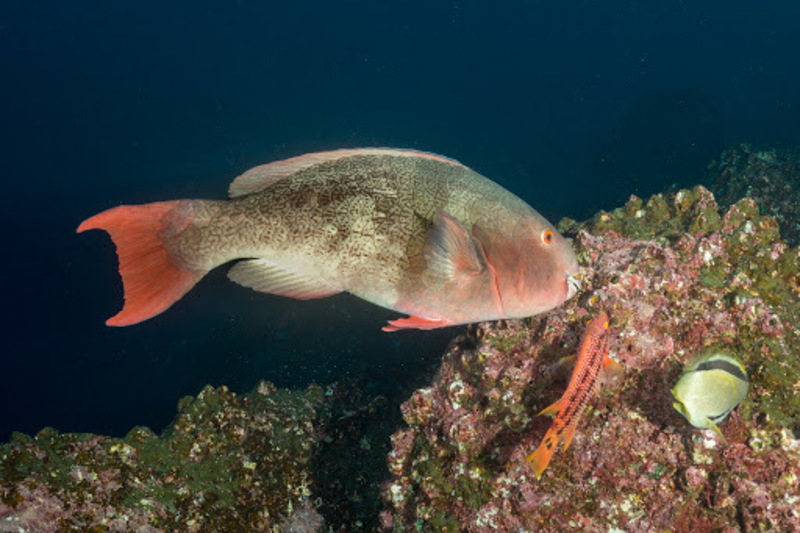

In [15]:
print(f'Image format: {img.format}')
print(f'Image format: {img.size}')
print(f'Image format: {img.mode}')
img

This particular sample is a 800x533 RGB image in JPEG format. It is important to understand whether all images share the same features. The following routine traverses the image folders, storing the dimensions, the modes, and the formats of all pictures. Then, we inspect the results.

In [39]:
image_dim1 = []
image_dim2 = []
image_mode = []
image_format = []
    
for df in range(len(data_folders)):
    dir_df = data_folders[df]
    df_supercats = os.listdir(dir_df)
    supercats_path = dir_df + '/'
    for supercat in df_supercats:
        cats_path = supercats_path + supercat + '/'
        df_cats = os.listdir(cats_path)
        for cat in df_cats:
            images_path = cats_path + cat
            df_cat = os.listdir(images_path)
            for image in df_cat:
                image_path = images_path + '/' + image
                img = Image.open(image_path)
                image_dim1.append(img.size[0])
                image_dim2.append(img.size[1])
                image_mode.append(img.mode)
                image_format.append(img.format)

In [40]:
print(np.unique(image_format))
print(np.unique(image_mode))

['JPEG']
['CMYK' 'L' 'RGB']


We see that format is JPEG in all cases; hence we can ignore this piece of information. <br>
On the contrary, there are three possible modes in our data: CMYK, L, and RGB. Below we see their frequencies.

In [41]:
image_mode = pd.Series(image_mode)
image_mode.value_counts()

RGB     124390
L           89
CMYK         2
dtype: int64

Since most images are RGB - less than 0.1% of the samples is not - we choose to maintain only RGB images, and discard the remainder, as this is unlikely to change the performance of our models. <br>
Finally, we see how many different image resolutions there are in the data:

In [42]:
image_dims = pd.Series([(x, y) for x, y in zip(image_dim1, image_dim2)])
f'There are {len(image_dims.unique())} different image dimensions.'

'There are 1063 different image dimensions.'

To make our data ready for the CNNs, images will be resized, from their 1063 different resolutions, to a common shape. This will involve destroying some information but, as long as the resizing is not particularly extreme, it should not impact performance significantly. We choose a common resolution of 200x200 pixels.

In [47]:
f'Average Image Resolution: {np.array(image_dim1).mean():.0f}x{np.array(image_dim2).mean():.0f}'

'Average Image Resolution: 743x644'

Since the average resolution is 743x644 pixels, we are also greatly reducing the size of the input tensors, thereby allowing for faster computations.

To allow for even faster training, we decide to subsample the total data set of images down to some fraction of its 124390 RGB pictures.

### Image Preprocessing and Model Folders

At this stage, we clean the data as decided during inspection. Then, we create the folders which will contain our cleaned images and whose data will be fed to the models. Images in the original directories, 'split_1' and 'split_2', will not be modified nor removed: this preprocessing will be done either when populating the model folders or afterwards. We conclude by rescaling pixel values and building the data generators.

The following routine traverses the image folders, storing non-RGB images and creating a dictionary mapping each image category to the number of its non-RGB images.

In [48]:
categories = {}
nonRGB = []
for data_folder in data_folders:
    df_supercats = os.listdir(data_folder)
    for supercat in df_supercats:
        cats_path = data_folder + '/' + supercat
        df_cats = os.listdir(cats_path)
        for cat in df_cats:
            images_path = cats_path + '/' + cat
            df_images = os.listdir(images_path)
            num_images = len(os.listdir(images_path))
            for img in df_images:
                img_path = images_path + '/' + img
                img = Image.open(img_path)
                if img.mode != 'RGB':
                    nonRGB.append(img_path)
                    num_images -= 1
            categories[cat] = num_images
                

In [49]:
categories = pd.Series(categories)

As previously stated, we want to reduce our data to allow faster computations and more experimentation with models.

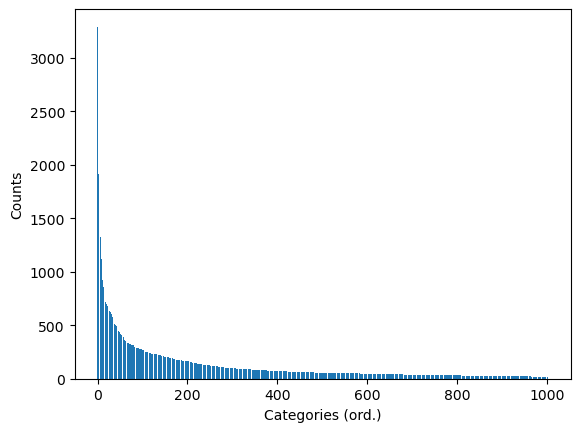

In [56]:
plt.bar(np.arange(len(categories)), categories.sort_values(ascending = False).values)
plt.xlabel('Categories (ord.)')
plt.ylabel('Counts')
plt.show()

We see that categories can differ greatly in the number of images they contain. Thus, subsampling cannot be conducted by sampling images completely at random, as this risks producing classes with very few instances. Instead, we will select a subset of all categories, and keep all images for those classes. This will be done by selecting a given fraction of classes, starting from the most numerous and in descending order by numerosity. Also, since the frequency of categories seems to exhibit a power law distribution, even taking a small fraction of classes will still select a large number of instances. We choose to maintain the top 10% of all classes in the data.

In [57]:
threshold_perc = 10
no_cats = len(categories)

In [58]:
cat_top = pd.Series(categories).nlargest(int(no_cats*threshold_perc/100))

In [59]:
print(f'Starting from {len(categories)} categories, for a total of {sum(categories)} images, the data have been reduced to {len(cat_top)} \
categories, for a total of {sum(cat_top)} images, choosing only the top 10% classes.')

Starting from 1003 categories, for a total of 124390 images, the data have been reduced to 100 categories, for a total of 58226 images, choosing only the top 10% classes.


In [60]:
print(f'The most present category has {cat_top[0]} images: {cat_top[0]/sum(cat_top)} of the top 10% classes.')

The most present category has 3290 images: 0.05650396729983169 of the top 10% classes.


With this selection, we halved our instances. Also, the most frequent category has around 5.6% of images in our subsample. This 5.6% is our baseline, at least in terms of accuracy: this is the accuracy which the simplest model, which just assigns each image to the most probable class overall, would obtain.

The model folders 'train', 'test', and 'validation' are created.

In [2]:
splits_folders = ['train', 'test', 'validation']

In [57]:
for s in splits_folders:
    os.mkdir(s)

The following routine populates our model folders with image data. For each top10%-category, it randomly splits its RGB images in train, test, and validation folders. The images are not yet resized, as this operation can be performed in a second phase. The train-validation-test split is done with the following spread: 60% of training data, 20% of validation data and 20% of test data. 

In [58]:
rem = 0.4 #: 1-train_size
test = 0.5 #: test_size/(1-train_size)

for data_folder in data_folders:
    df_supercats = os.listdir(data_folder)
    for supercat in df_supercats:
        cats_path = data_folder + '/' + supercat
        df_cats = os.listdir(cats_path)
        for cat in df_cats:
            if cat not in cat_top.index:
                continue
            images_path = cats_path + '/' + cat
            df_images = os.listdir(images_path)
            for img in df_images:
                img_path = images_path + '/' + img
                if img_path in nonRGB:
                    df_images.remove(img)
            X_train, X_rem = train_test_split(df_images, test_size = rem, random_state = 1)
            X_val, X_test = train_test_split(X_rem, test_size = test, random_state = 1)
            for split_folder, split_images in zip(splits_folders, (X_train, X_test, X_val)):
                split_folder_cat = split_folder + '/' + cat
                os.mkdir(split_folder_cat)
                for image in split_images:
                    source_img = images_path + '/' + image
                    source_img = Image.open(source_img)
                    dest_path = split_folder_cat + '/' + image
                    source_img.save(dest_path)               

Finally, the preprocessing part is concluded by rescaling pixels to the [0, 1] interval, resizing images to 200x200 pixels, setting a batch size for mini-batch SGD of 128 samples, and, thus, building data generators for the training and validation model folders.

In [4]:
sizex = 200 #images x-axis resizing
sizey = 200 #images y-axis resizing
sizeB = 128 #batch size

In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255)
validation_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

In [6]:
train_generator = train_datagen.flow_from_directory(
    directory = 'train',
    target_size = (sizex, sizey),
    batch_size = sizeB,
    class_mode = 'categorical')

Found 34900 images belonging to 100 classes.


In [7]:
validation_generator = validation_datagen.flow_from_directory(
    directory = 'validation',
    target_size = (sizex, sizey),
    batch_size = sizeB,
    class_mode = 'categorical')

Found 11645 images belonging to 100 classes.


In [8]:
test_generator = test_datagen.flow_from_directory(
    directory = 'test',
    target_size = (sizex, sizey),
    batch_size = sizeB,
    class_mode = 'categorical')

Found 11690 images belonging to 100 classes.


## Modeling: Optimization

Now that the images are prepared, we start trying some models on the data. The only model architecture that will be implemented is the convolutional neural network, and, based on this architecture, different configurations will be tested. In general, for all models we will set RMSprop as the optimizer, as it is generally a good choice, and the categorical crossentropy as the loss function, since we are concerned with a multiclass classification. Other common features are 3x3 filters, ReLU activations, stride set to 1, and padding such that convolutions do not resize their inputs. In this section, different models are implemented, with the focus on the detection of a good configuration, which is capable of fitting the data with sufficient flexibility, even at the cost of overfitting, for the moment. For each configuration, the state of the model with best validation accuracy is saved (Note that Keras implements 'accuracy' as categorical accuracy, deu to the presence of multiple classes). (Not all models that have been considered and tried have been reported below.)

### Model of Little Capacity

Although the objective and usefulness of a model only resides in its ability to generalize, that is, in its performance on 'new' data, our primary concern is to find a model which is capable of representing the complexity of the problem which is to solve. Thus, before caring of overfitting, we must identify a configuration which is not prone to underfitting and has sufficiently large capacity. <br>
We start by fitting a relatively simple CNN to our data. It is quite shallow, as it merely presents two convolutional layers, with 8 and 16 filters, and a fully connected classifier which is ultimately based on just 16 activations. This last configuration choice was adopted to forcefully downsize the parameter space of the model, which would otherwise be very big due to the few pooling layers. In the end, the model still trains over 600 thousand parameters, which are not few, though it cannot build complex feature maps. <br>
The model is trained for 20 epochs, with a batch size of 128 samples.

In [22]:
model_s = models.Sequential()

In [23]:
model_s.add(layers.Conv2D(8, (3, 3), activation =  'relu', padding = 'same', input_shape = (sizex, sizey, 3)))
model_s.add(layers.MaxPooling2D((2, 2)))
model_s.add(layers.Conv2D(16, (3, 3), activation =  'relu', padding = 'same', input_shape = (sizex, sizey, 3)))
model_s.add(layers.MaxPooling2D((2, 2)))
model_s.add(layers.Flatten())
model_s.add(layers.Dense(16, activation = 'relu'))
model_s.add(layers.Dense(100 , activation = 'softmax'))

In [24]:
model_s.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 200, 200, 8)       224       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 100, 100, 8)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 100, 100, 16)      1168      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 50, 50, 16)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 40000)             0         
                                                                 
 dense_5 (Dense)             (None, 16)               

In [25]:
model_s.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

In [26]:
model_s_checkpoint = ModelCheckpoint(
    filepath="model_s_e20_Best.keras",
    monitor="val_accuracy",
    save_best_only=True,
)


In [27]:
history_model_s = model_s.fit(
    train_generator,
    epochs = 20,
    batch_size = 128,
    validation_data = validation_generator,
    callbacks = [model_s_checkpoint]
)  

Epoch 1/20
273/273 [==============================] - 723s 3s/step - loss: 4.4235 - accuracy: 0.0556 - val_loss: 4.3508 - val_accuracy: 0.0589
Epoch 2/20
273/273 [==============================] - 738s 3s/step - loss: 4.2719 - accuracy: 0.0734 - val_loss: 4.2437 - val_accuracy: 0.0755
Epoch 3/20
273/273 [==============================] - 698s 3s/step - loss: 4.1334 - accuracy: 0.0868 - val_loss: 4.1290 - val_accuracy: 0.0924
Epoch 4/20
273/273 [==============================] - 703s 3s/step - loss: 4.0303 - accuracy: 0.1030 - val_loss: 4.0391 - val_accuracy: 0.1030
Epoch 5/20
273/273 [==============================] - 725s 3s/step - loss: 3.9543 - accuracy: 0.1099 - val_loss: 4.0145 - val_accuracy: 0.1074
Epoch 6/20
273/273 [==============================] - 691s 3s/step - loss: 3.8908 - accuracy: 0.1173 - val_loss: 4.0114 - val_accuracy: 0.1038
Epoch 7/20
273/273 [==============================] - 689s 3s/step - loss: 3.8336 - accuracy: 0.1220 - val_loss: 3.9537 - val_accuracy: 0.1101

In [29]:
model_s.save('model_s.h5')

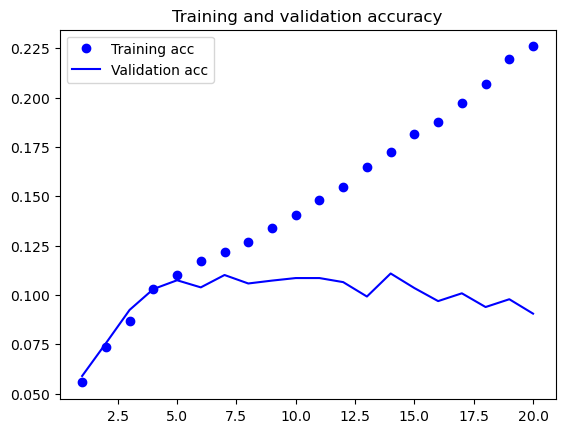

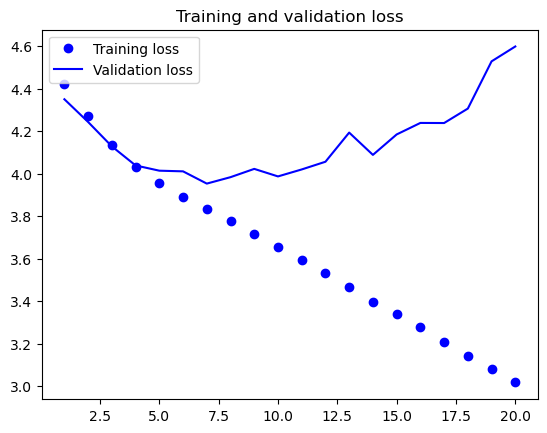

In [65]:
acc = history_model_s.history['accuracy']
val_acc = history_model_s.history['val_accuracy']
loss = history_model_s.history['loss']
val_loss = history_model_s.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [30]:
np.save('history_model_s.npy', history_model_s.history)

Even though the model was not very complex nor very deep, it is already capable of overfitting, which even happens fairly early, around the 6th epoch. It doubles the baseline accuracy, reaching 11% of accuracy on validation data. However, even if prone to overfitting, the model is actually too simple in its specification: most of the parameters are in the fully-connected classifier, where the network overfits by memorizing non-general patterns in the training data, while the convolutional base of the network would probably benefit from being deeper, and so able to detect high-level visual features. Then, the model is clearly sub-optimal, and serves as a starting point to improve on.

### Models of Higher Capacity

In what follows, we extend the previous model, by increasing the number and the size of its layers, thereby producing deeper, more hierarchical, more complex models. Two different configurations are implemented below. <br>
In this first trial, the model configuration presents 4 convolutional layers, and the number of filters goes from 16 to 128. The model accomodates almost 5 million parameters. <br>
Training lasts for at maximum 30 epochs, but for computational reasons it is stopped once there is enough evidence of overfitting (early stopping is applied for this purpose, rather than for regularization).

In [72]:
model1 = models.Sequential()

In [73]:
model1.add(layers.Conv2D(16, (3, 3), activation =  'relu', padding = 'same', input_shape = (sizex, sizey, 3)))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Flatten())
model1.add(layers.Dense(256, activation = 'relu'))
model1.add(layers.Dense(100, activation = 'softmax'))

In [74]:
model1.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 100, 100, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_48 (Conv2D)          (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 25, 25, 64)      

In [75]:
model1.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

In [76]:
model1_checkpoint = ModelCheckpoint(
    filepath="model1_e30_Best.keras",
    monitor="val_accuracy",
    save_best_only=True,
)

model1_earlystop = EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 0.001,
    patience = 10,
    verbose = 1,
    mode = 'auto'
)

In [77]:
history_model1 = model1.fit(
    train_generator,
    epochs = 30,
    batch_size = sizeB,
    validation_data = validation_generator,
    callbacks = [model1_earlystop, model1_checkpoint]
)  

Epoch 1/30
273/273 [==============================] - 708s 3s/step - loss: 4.2914 - accuracy: 0.0753 - val_loss: 4.1716 - val_accuracy: 0.0891
Epoch 2/30
273/273 [==============================] - 730s 3s/step - loss: 3.9125 - accuracy: 0.1229 - val_loss: 3.8266 - val_accuracy: 0.1311
Epoch 3/30
273/273 [==============================] - 746s 3s/step - loss: 3.6260 - accuracy: 0.1644 - val_loss: 3.6816 - val_accuracy: 0.1579
Epoch 4/30
273/273 [==============================] - 733s 3s/step - loss: 3.3043 - accuracy: 0.2155 - val_loss: 3.7354 - val_accuracy: 0.1478
Epoch 5/30
273/273 [==============================] - 742s 3s/step - loss: 2.9044 - accuracy: 0.2885 - val_loss: 3.7211 - val_accuracy: 0.1742
Epoch 6/30
273/273 [==============================] - 743s 3s/step - loss: 2.4110 - accuracy: 0.3940 - val_loss: 4.0307 - val_accuracy: 0.1647
Epoch 7/30
273/273 [==============================] - 729s 3s/step - loss: 1.8331 - accuracy: 0.5224 - val_loss: 4.5175 - val_accuracy: 0.1505

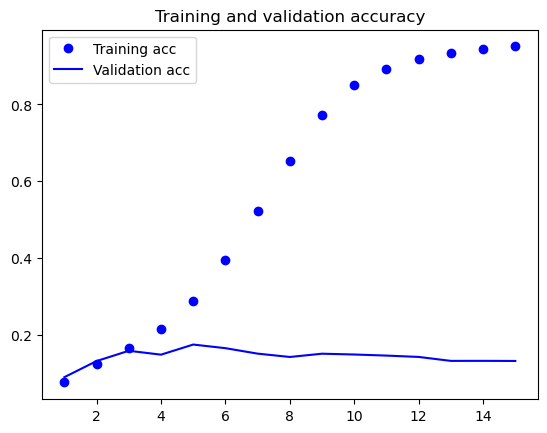

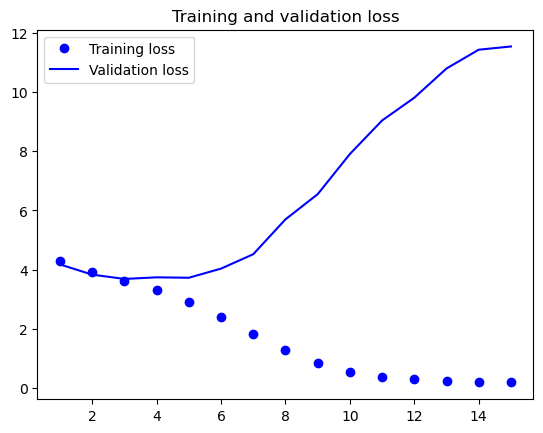

In [66]:
acc = history_model1.history['accuracy']
val_acc = history_model1.history['val_accuracy']
loss = history_model1.history['loss']
val_loss = history_model1.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
np.save('history_model1.npy', history_model1.history)

Compared to the previous model, this configuration overfits much faster. This is a consequence of the greater complexity. However, the same higher complexity leads to a large increase in accuracy, which is above 17% for the best parameters state.

This alternative model below is even deeper than the previous one. It has almost 6 million parameters, and a much deeper convolutional base.

In [79]:
model2 = models.Sequential()

In [80]:
model2.add(layers.Conv2D(16, (3, 3), activation =  'relu', input_shape = (sizex, sizey, 3)))
model2.add(layers.Conv2D(16, (3, 3), activation = 'relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))
model2.add(layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same'))
model2.add(layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same'))
model2.add(layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(256, (3, 3), activation = 'relu', padding = 'same'))
model2.add(layers.Conv2D(256, (3, 3), activation = 'relu', padding = 'same'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(512, activation = 'relu'))
model2.add(layers.Dense(100, activation = 'softmax'))

In [81]:
model2.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 198, 198, 16)      448       
                                                                 
 conv2d_51 (Conv2D)          (None, 196, 196, 16)      2320      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 98, 98, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_52 (Conv2D)          (None, 98, 98, 32)        4640      
                                                                 
 conv2d_53 (Conv2D)          (None, 98, 98, 32)        9248      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 49, 49, 32)       0         
 g2D)                                                 

In [82]:
model2.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

In [83]:
model2_checkpoint = ModelCheckpoint(
    filepath="model2_e30_Best.keras",
    monitor="val_accuracy",
    save_best_only=True,
)

model2_earlystop = EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 0.001,
    patience = 7,
    verbose = 1,
    mode = 'auto'
)

In [84]:
history_model2 = model2.fit(
    train_generator,
    epochs = 30,
    batch_size = sizeB,
    validation_data = validation_generator,
    callbacks = [model2_earlystop, model2_checkpoint]
)  

Epoch 1/30
273/273 [==============================] - 859s 3s/step - loss: 4.4912 - accuracy: 0.0554 - val_loss: 4.3886 - val_accuracy: 0.0597
Epoch 2/30
273/273 [==============================] - 843s 3s/step - loss: 4.3144 - accuracy: 0.0629 - val_loss: 4.2418 - val_accuracy: 0.0745
Epoch 3/30
273/273 [==============================] - 852s 3s/step - loss: 4.1958 - accuracy: 0.0793 - val_loss: 4.0986 - val_accuracy: 0.0914
Epoch 4/30
273/273 [==============================] - 867s 3s/step - loss: 4.0288 - accuracy: 0.1022 - val_loss: 4.0166 - val_accuracy: 0.1072
Epoch 5/30
273/273 [==============================] - 873s 3s/step - loss: 3.8309 - accuracy: 0.1309 - val_loss: 4.0015 - val_accuracy: 0.1148
Epoch 6/30
273/273 [==============================] - 854s 3s/step - loss: 3.5587 - accuracy: 0.1736 - val_loss: 4.0072 - val_accuracy: 0.1205
Epoch 7/30
273/273 [==============================] - 852s 3s/step - loss: 3.1892 - accuracy: 0.2379 - val_loss: 4.0014 - val_accuracy: 0.1331

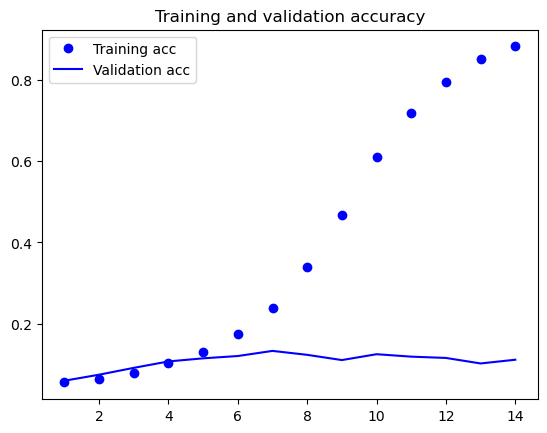

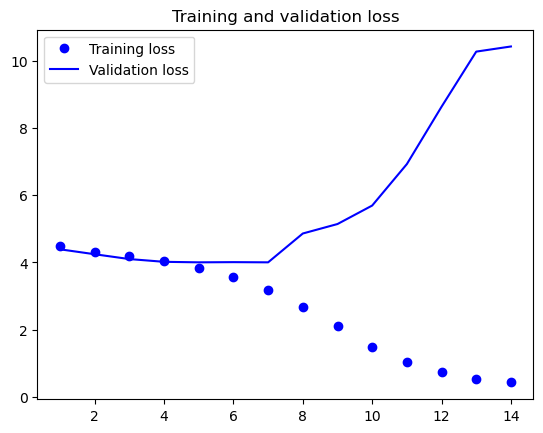

In [67]:
acc = history_model2.history['accuracy']
val_acc = history_model2.history['val_accuracy']
loss = history_model2.history['loss']
val_loss = history_model2.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
np.save('history_model2.npy', history_model2.history)

Also for this configuration we observe fast overfitting, but here the performance is damaged by the greater flexibility. As a consequence, we choose the first one of these two bigger configurations, and use it as a base for further improvements.

## Modeling: Regularization

Now that we have a model which is adequate for the complexity of the problem and is capable of overfitting, we regularize it to limit training data memorization and improve generalization. Before doing so, as a first step, we decide to increase the batch size, from 128 to 256, as this will lead to more informative, less noisy gradients, thereby additionally improving the fit to the training data before restraining it.

In [9]:
sizeB = 256

In [10]:
train_generator = train_datagen.flow_from_directory(
    directory = 'train',
    target_size = (sizex, sizey),
    batch_size = sizeB,
    class_mode = 'categorical')

validation_generator = validation_datagen.flow_from_directory(
    directory = 'validation',
    target_size = (sizex, sizey),
    batch_size = sizeB,
    class_mode = 'categorical')

test_generator_2 = test_datagen.flow_from_directory(
    directory = 'test',
    target_size = (sizex, sizey),
    batch_size = sizeB,
    class_mode = 'categorical')

Found 34900 images belonging to 100 classes.
Found 11645 images belonging to 100 classes.
Found 11690 images belonging to 100 classes.


To regularize our model, we make use of two tools: data augmentation and dropout. Through data augmentation, we feed our CNN with additional images derived from transforming the original instances thorough a series of operations, such as rotations, shifts, and flips. Through dropout, we switch off a random set of activations during training, thereby limiting the impact of noise on learned patterns.

In [11]:
train_datagen_da = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,)

train_generator_da = train_datagen_da.flow_from_directory(
    directory = 'train',
    target_size = (sizex, sizey),
    batch_size = sizeB,
    class_mode = 'categorical')


Found 34900 images belonging to 100 classes.


The model below is the network which proved to be the best in the previous section, now regularized through data augmentation and dropout layers. Dropout is applied after each densely connected layer, and the proportion of dropped-out activations is set to 0.5. The model is trained for 50 epochs.

In [11]:
model3 = models.Sequential()

2023-01-25 10:37:21.929104: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-25 10:37:21.934005: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [12]:
model3.add(layers.Conv2D(16, (3, 3), activation =  'relu', padding = 'same', input_shape = (sizex, sizey, 3)))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Flatten())
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(256, activation = 'relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(100, activation = 'softmax'))

In [13]:
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 25, 64)       0

In [14]:
model3.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

In [15]:
model3_checkpoint = ModelCheckpoint(
    filepath="model3_e50_Best.keras",
    monitor="val_accuracy",
    save_best_only=True,
)

model3_earlystop = EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 0.001,
    patience = 15,
    verbose = 1,
    mode = 'auto'
)

In [17]:
history_model3 = model3.fit(
    train_generator_da,
    epochs = 50,
    batch_size = sizeB,
    validation_data = validation_generator,
    callbacks = [model3_earlystop, model3_checkpoint]
)  

Epoch 1/50
137/137 [==============================] - 1334s 10s/step - loss: 4.4289 - accuracy: 0.0539 - val_loss: 4.3034 - val_accuracy: 0.0678
Epoch 2/50
137/137 [==============================] - 1628s 12s/step - loss: 4.2655 - accuracy: 0.0766 - val_loss: 4.1506 - val_accuracy: 0.0897
Epoch 3/50
137/137 [==============================] - 1562s 11s/step - loss: 4.1611 - accuracy: 0.0894 - val_loss: 4.0593 - val_accuracy: 0.1030
Epoch 4/50
137/137 [==============================] - 1573s 11s/step - loss: 4.0805 - accuracy: 0.0982 - val_loss: 3.9252 - val_accuracy: 0.1267
Epoch 5/50
137/137 [==============================] - 1849s 14s/step - loss: 4.0167 - accuracy: 0.1073 - val_loss: 3.8820 - val_accuracy: 0.1312
Epoch 6/50
137/137 [==============================] - 2280s 17s/step - loss: 3.9688 - accuracy: 0.1127 - val_loss: 3.9627 - val_accuracy: 0.1182
Epoch 7/50
137/137 [==============================] - 2316s 17s/step - loss: 3.9242 - accuracy: 0.1194 - val_loss: 3.7804 - val_ac

In [ ]:
model3.save('model3.h5')

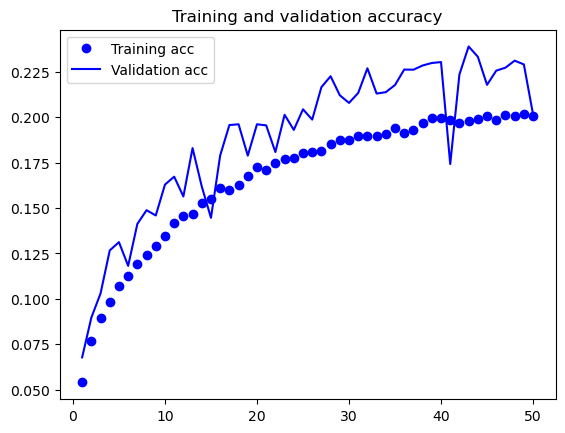

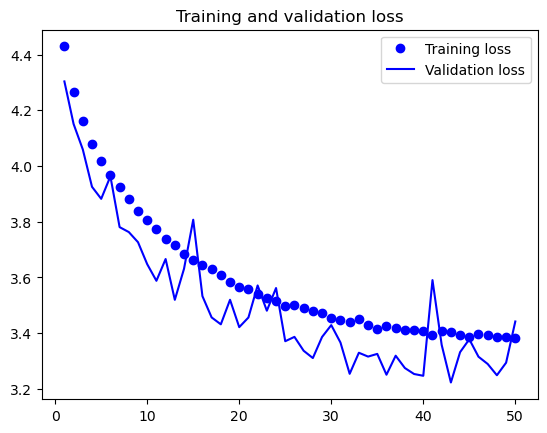

In [18]:
acc = history_model3.history['accuracy']
val_acc = history_model3.history['val_accuracy']
loss = history_model3.history['loss']
val_loss = history_model3.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
np.save('history_model3.npy', history_model3.history)

This regularization prevents the model from overfitting, thereby making training and validation metrics move together, in a very different fashion from the behaviour of the unregularized model. This produces a considerable increase in performance, which stabilizes between the 30th and 40th epochs, with a peak validation accuracy of around 24%.

Below, a second, deeper, regularized configuration is implemented, with similar results.

In [8]:
model4 = models.Sequential()

In [9]:
model4.add(layers.Conv2D(16, (3, 3), activation =  'relu', padding = 'same', input_shape = (sizex, sizey, 3)))
model4.add(layers.Conv2D(16, (3, 3), activation = 'relu', padding = 'same'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))
model4.add(layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same'))
model4.add(layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same'))
model4.add(layers.Conv2D(128, (3, 3), activation = 'relu', padding = 'same'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(256, (3, 3), activation = 'relu', padding = 'same'))
model4.add(layers.Conv2D(256, (3, 3), activation = 'relu', padding = 'same'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Flatten())
model4.add(layers.Dense(256, activation = 'relu'))
model4.add(layers.Dropout(0.5))
model4.add(layers.Dense(100, activation = 'softmax'))

In [10]:
model4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 200, 200, 16)      448       
                                                                 
 conv2d_11 (Conv2D)          (None, 200, 200, 16)      2320      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 100, 100, 16)     0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 100, 100, 32)      4640      
                                                                 
 conv2d_13 (Conv2D)          (None, 100, 100, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                  

In [11]:
model4.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

In [12]:
model4_checkpoint = ModelCheckpoint(
    filepath="model4_e50_Best.keras",
    monitor="val_accuracy",
    save_best_only=True,
)

model4_earlystop = EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 0.001,
    patience = 10,
    verbose = 1,
    mode = 'auto'
)

In [13]:
history_model4 = model4.fit(
    train_generator_da,
    epochs = 50,
    batch_size = sizeB,
    validation_data = validation_generator,
    callbacks = [model4_earlystop, model4_checkpoint]
)  

Epoch 1/50
137/137 [==============================] - 1253s 9s/step - loss: 4.4633 - accuracy: 0.0505 - val_loss: 4.3923 - val_accuracy: 0.0621
Epoch 2/50
137/137 [==============================] - 1262s 9s/step - loss: 4.3720 - accuracy: 0.0578 - val_loss: 4.2946 - val_accuracy: 0.0632
Epoch 3/50
137/137 [==============================] - 1265s 9s/step - loss: 4.3242 - accuracy: 0.0612 - val_loss: 4.2516 - val_accuracy: 0.0638
Epoch 4/50
137/137 [==============================] - 1307s 10s/step - loss: 4.2779 - accuracy: 0.0661 - val_loss: 4.2049 - val_accuracy: 0.0756
Epoch 5/50
137/137 [==============================] - 1269s 9s/step - loss: 4.2346 - accuracy: 0.0733 - val_loss: 4.2052 - val_accuracy: 0.0709
Epoch 6/50
137/137 [==============================] - 1305s 10s/step - loss: 4.1909 - accuracy: 0.0776 - val_loss: 4.0983 - val_accuracy: 0.0876
Epoch 7/50
137/137 [==============================] - 1264s 9s/step - loss: 4.1508 - accuracy: 0.0838 - val_loss: 4.0433 - val_accurac

In [ ]:
model4.save('model4.h5')

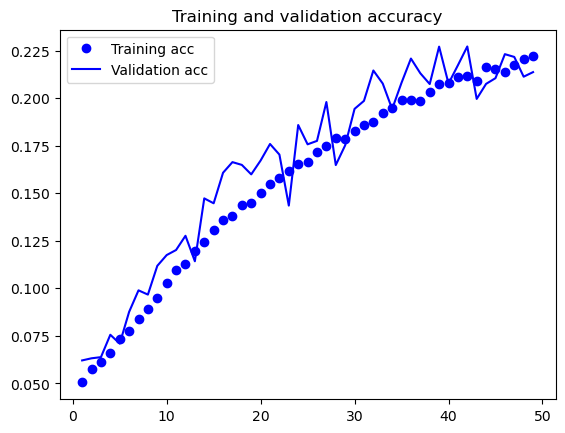

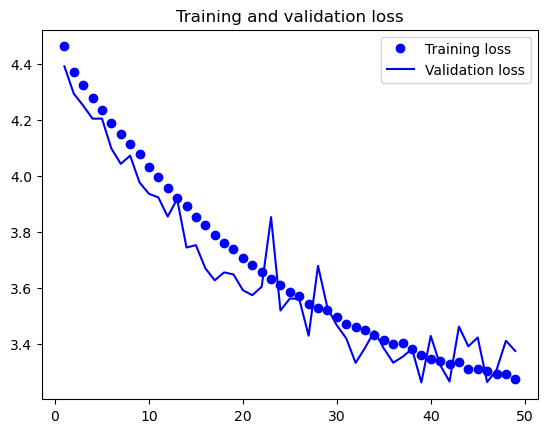

In [14]:
acc = history_model4.history['accuracy']
val_acc = history_model4.history['val_accuracy']
loss = history_model4.history['loss']
val_loss = history_model4.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Modeling: Transfer Learning

In the previous section, we obtained a regularized model which has a classification accuracy on hold-out data of around 1/4, using 60% of the full data. In this section, we try to go beyond this performance by leveraging a pretrained model, specifically VGG16. We consider and implement 3 different approaches to transfer learning: feature extraction without data augmentation, feature extraction with data augmentation, and fine-tuning of the pretrained model.

Below, the convolutional base of VGG16, trained on the ImageNet database, is loaded and inspected.

In [17]:
VGG16_ConvBase = vgg16.VGG16(weights = 'imagenet',
                            include_top = False,
                             input_shape = (200, 200, 3))

In [18]:
VGG16_ConvBase.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [19]:
featuremap_x = 6
featuremap_y = 6
featuremap_d = 512

### Feature Extraction without Data Augmentation

The first approach we adopt to exploit VGG16 for our classification task involves passing each image to VGG16 convolutional base, obtaining feature maps. Thus, we make use of VGG16 learned features to transform our data to a more easily usable representation: presence maps of VGG16's 'visual concepts' learned on ImageNet. This presence maps are then fed to the densely-connected classifier. This type of transfer learning has the advantage of being computationally very fast: once the features have been extracted, we just need to train fully connected layers, which are trained faster than convolutional layers.

Below, we implement this approach, by collecting the images in Dataset objects and converting them into feature maps.

In [20]:
sizeB = 256

In [21]:
train_dataset = image_dataset_from_directory(
    "train",
    image_size = (sizex, sizey),
    batch_size = sizeB)
validation_dataset = image_dataset_from_directory(
    "validation",
    image_size = (sizex, sizey),
    batch_size = sizeB)
test_dataset = image_dataset_from_directory(
    "test",
    image_size = (sizex, sizey),
    batch_size = sizeB)

Found 34900 files belonging to 100 classes.
Found 11645 files belonging to 100 classes.
Found 11690 files belonging to 100 classes.


In [22]:
def feature_extraction(dataset):
    b = 1
    features = []
    labels = []
    for data_batch, labels_batch in dataset:
        preprocessed_batch = vgg16.preprocess_input(data_batch)
        features_batch = VGG16_ConvBase.predict(preprocessed_batch)
        features.append(features_batch)
        labels.append(labels_batch)
        if b%10 == 0:
            print(f'Batch {b} done')
        b+=1
    return np.concatenate(features), np.concatenate(labels)

In [23]:
train_features, train_labels = feature_extraction(train_dataset)
val_features, val_labels = feature_extraction(validation_dataset)
test_features, test_labels = feature_extraction(test_dataset)

8/8 [==============================] - 6s 702ms/step
Batch 10 done
8/8 [==============================] - 6s 805ms/step
Batch 20 done
8/8 [==============================] - 6s 739ms/step
Batch 30 done
8/8 [==============================] - 7s 836ms/step
Batch 40 done
6/6 [==============================] - 5s 711ms/step


The following model is merely the densely connected classifier, whick takes directly as input the (flattened) VGG16 feature maps of the images.

In [101]:
model5 = models.Sequential()

In [102]:
model5.add(layers.Flatten(input_shape = (featuremap_x, featuremap_y, featuremap_d)))
model5.add(layers.Dense(512, activation = 'relu'))
model5.add(layers.Dropout(0.5))
model5.add(layers.Dense(100, activation = 'softmax'))

In [103]:
model5.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 18432)             0         
                                                                 
 dense_9 (Dense)             (None, 512)               9437696   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 100)               51300     
                                                                 
Total params: 9,488,996
Trainable params: 9,488,996
Non-trainable params: 0
_________________________________________________________________


In [104]:
model5.compile(optimizer = 'rmsprop',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [105]:
model5_checkpoint = ModelCheckpoint(
    filepath="model5_e20_Best.keras",
    monitor="val_accuracy",
    save_best_only=True,
)

In [106]:
history_model5 = model5.fit(train_features, train_labels,
                          epochs = 20,
                            batch_size = sizeB,
                          validation_data = (val_features, val_labels),
                          callbacks = [model5_checkpoint])

Epoch 1/20
137/137 [==============================] - 13s 89ms/step - loss: 5.5939 - accuracy: 0.1165 - val_loss: 3.7189 - val_accuracy: 0.2094
Epoch 2/20
137/137 [==============================] - 11s 78ms/step - loss: 3.9264 - accuracy: 0.1959 - val_loss: 3.4542 - val_accuracy: 0.2568
Epoch 3/20
137/137 [==============================] - 11s 83ms/step - loss: 3.6067 - accuracy: 0.2314 - val_loss: 3.3485 - val_accuracy: 0.2776
Epoch 4/20
137/137 [==============================] - 10s 75ms/step - loss: 3.4907 - accuracy: 0.2531 - val_loss: 3.2084 - val_accuracy: 0.2961
Epoch 5/20
137/137 [==============================] - 10s 73ms/step - loss: 3.3447 - accuracy: 0.2737 - val_loss: 3.2211 - val_accuracy: 0.3068
Epoch 6/20
137/137 [==============================] - 10s 72ms/step - loss: 3.2605 - accuracy: 0.2879 - val_loss: 3.1741 - val_accuracy: 0.3077
Epoch 7/20
137/137 [==============================] - 12s 86ms/step - loss: 3.1851 - accuracy: 0.2971 - val_loss: 3.1828 - val_accuracy:

In [107]:
model5.save('model5.h5')

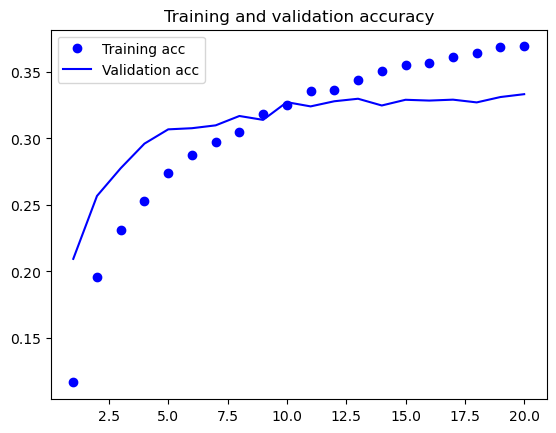

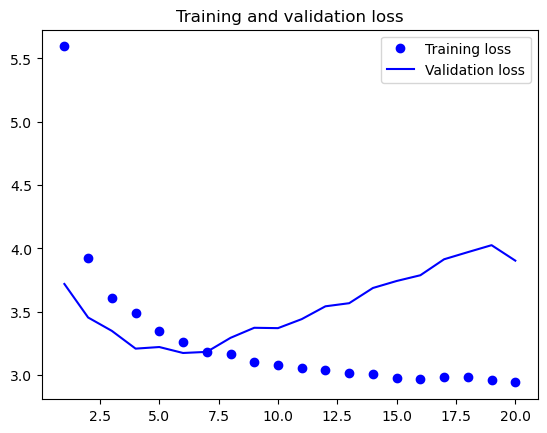

In [108]:
acc = history_model5.history['accuracy']
val_acc = history_model5.history['val_accuracy']
loss = history_model5.history['loss']
val_loss = history_model5.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [109]:
np.save('history_model5.npy', history_model5.history)

Through this approach, we reach a validation accuracy of around 33%. However, it seems that, despite dropout, the model is prone to overfitting, which is particularly clear when looking at the dynamics of validation loss; indeed, not only the validation metrics stop improving in a few epochs during training, but the validation loss increases, and does so while validation accuracy is more or less constant. Desite the better accuracy, validation loss rapidly overtakes that of the regularized model (trained from scratch). Thus it seems that overfitting may be a serious problem in this model.

### Feature Extraction with Data Augmentation

One way to approach the overfitting problem of the previous model is through data augmentation. Clearly, this prevents the computational speed-up of the previous method, which passed each image just once through the convolutional base of VGG16. Instead, now we extend the convolutional base of VGG16 by adding the dense layers on top, and train, with the base frozen.

In [22]:
VGG16_ConvBase.trainable = False

In [23]:
model6 = models.Sequential()

In [24]:
model6.add(VGG16_ConvBase)
model6.add(layers.Flatten(input_shape = (featuremap_x, featuremap_y, featuremap_d)))
model6.add(layers.Dense(512, activation = 'relu'))
model6.add(layers.Dropout(0.2))
model6.add(layers.Dense(100, activation = 'softmax'))

In [25]:
model6.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 18432)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               9437696   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 100)               51300     
                                                                 
Total params: 24,203,684
Trainable params: 9,488,996
Non-trainable params: 14,714,688
_________________________________________________________________


In [26]:
model6.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [27]:
model6_checkpoint = ModelCheckpoint(
    filepath="model6_2_e50_Best.keras",
    monitor="val_accuracy",
    save_best_only=True,
)

model6_earlystop = EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 0.001,
    patience = 10,
    verbose = 1,
    mode = 'auto'
)

In [28]:
history_model6 = model6.fit(train_generator_da,
                          epochs = 50,
                          validation_data = validation_generator,
                          callbacks = [model6_earlystop, model6_checkpoint])

Epoch 1/50
137/137 [==============================] - 1443s 11s/step - loss: 4.9242 - accuracy: 0.0641 - val_loss: 3.9406 - val_accuracy: 0.1103
Epoch 2/50
137/137 [==============================] - 1512s 11s/step - loss: 3.9613 - accuracy: 0.1144 - val_loss: 3.6215 - val_accuracy: 0.1612
Epoch 3/50
137/137 [==============================] - 1432s 10s/step - loss: 3.7551 - accuracy: 0.1375 - val_loss: 3.4486 - val_accuracy: 0.1897
Epoch 4/50
137/137 [==============================] - 1431s 10s/step - loss: 3.6600 - accuracy: 0.1520 - val_loss: 3.3056 - val_accuracy: 0.2047
Epoch 5/50
137/137 [==============================] - 1475s 11s/step - loss: 3.5820 - accuracy: 0.1644 - val_loss: 3.2629 - val_accuracy: 0.2130
Epoch 6/50
137/137 [==============================] - 1508s 11s/step - loss: 3.5355 - accuracy: 0.1677 - val_loss: 3.2265 - val_accuracy: 0.2180
Epoch 7/50
137/137 [==============================] - 1469s 11s/step - loss: 3.4993 - accuracy: 0.1733 - val_loss: 3.1562 - val_ac

In [29]:
model6.save('model6.h5')

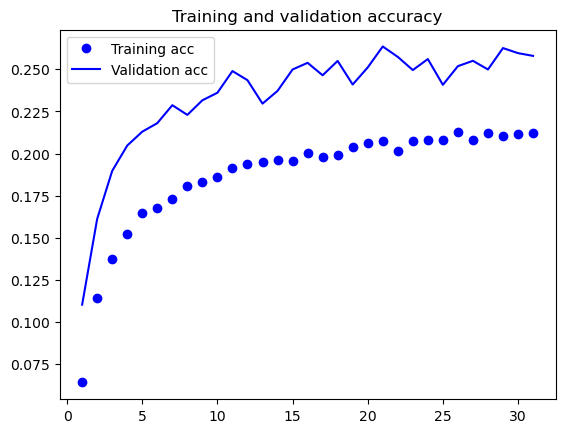

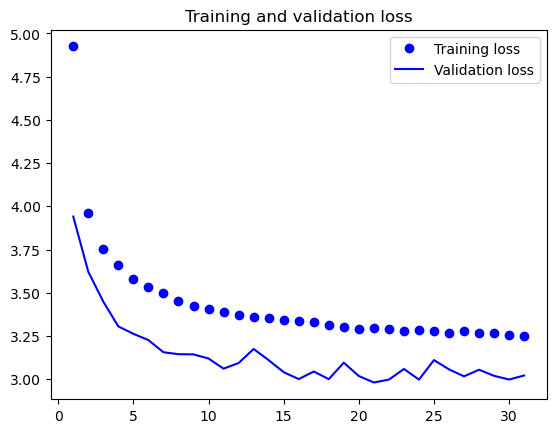

In [30]:
acc = history_model6.history['accuracy']
val_acc = history_model6.history['val_accuracy']
loss = history_model6.history['loss']
val_loss = history_model6.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [31]:
np.save('history_model6.npy', history_model6.history)

With this model, we obtain a validation accuracy of 26%, but with a considerably smaller validation loss, both with respect to feature extraction without data augmentation and to the regularized model (trained from scratch).

### Fine-tuning VGG16

The fact that the previous approaches could not lead to significant improvements in both validation loss and accuracy with respect to the regularized model trained from scratch, but at most just one of the metrics, and that controlling overfitting did not completely improved on feature extraction, suggests that the high-level features which are learned by VGG16 may not be so adequate for our task. Whereas very hierarchical features could be little relevant to our specific classes, more general, basic concepts, that is, the features learned in the first convolutional layers, may be more applicable. Thus, a way to improve on the previous results would be to train not only the fully-connected classifier, but also the top convolutional layers, in order to adapt the most specific features to our problem.

Below, the last four layers of the convolutional base of VGG16 are now set as trainable. Then, we train both these convolutional layers and the dense layers at the top. The dense layers are not trained from scratch, otherwise the error signal will be too large and could destroy the learned features that we want to fine-tune. Thus, the dense layers used are those trained in the previous part, when doing feature extraction with data augmentation. Again for the reason of limiting the modifications to the high-level features, we fine-tune the model using the RMSprop optimizer with a very low learning rate.

In [27]:
VGG16_ConvBase.trainable = True

In [28]:
for layer in VGG16_ConvBase.layers[:-4]:
    layer.trainable = False

In [29]:
model6.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 18432)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               9437696   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 100)               51300     
                                                                 
Total params: 24,203,684
Trainable params: 16,568,420
Non-trainable params: 7,635,264
_________________________________________________________________


In [30]:
model6.compile(optimizer = keras.optimizers.RMSprop(learning_rate=1e-5),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [31]:
model6FT_checkpoint = ModelCheckpoint(
    filepath="model6FT_e50_Best.keras",
    monitor="val_accuracy",
    save_best_only=True,
)

model6FT_earlystop = EarlyStopping(
    monitor = 'val_accuracy',
    min_delta = 0.001,
    patience = 10,
    verbose = 1,
    mode = 'auto'
)

In [32]:
history_model6FT = model6.fit(train_generator_da,
                          epochs = 50,
                          validation_data = validation_generator,
                          callbacks = [model6FT_earlystop, model6FT_checkpoint])

Epoch 1/50
137/137 [==============================] - 1653s 12s/step - loss: 2.8960 - accuracy: 0.2670 - val_loss: 2.7357 - val_accuracy: 0.3055
Epoch 2/50
137/137 [==============================] - 1530s 11s/step - loss: 2.8659 - accuracy: 0.2716 - val_loss: 2.7276 - val_accuracy: 0.3076
Epoch 3/50
137/137 [==============================] - 1554s 11s/step - loss: 2.8503 - accuracy: 0.2770 - val_loss: 2.6897 - val_accuracy: 0.3130
Epoch 4/50
137/137 [==============================] - 1538s 11s/step - loss: 2.8276 - accuracy: 0.2776 - val_loss: 2.6816 - val_accuracy: 0.3151
Epoch 5/50
137/137 [==============================] - 1608s 12s/step - loss: 2.8136 - accuracy: 0.2826 - val_loss: 2.6832 - val_accuracy: 0.3167
Epoch 6/50
137/137 [==============================] - 1589s 12s/step - loss: 2.8000 - accuracy: 0.2791 - val_loss: 2.6642 - val_accuracy: 0.3205
Epoch 7/50
137/137 [==============================] - 1570s 11s/step - loss: 2.7797 - accuracy: 0.2879 - val_loss: 2.6671 - val_ac

In [33]:
model6.save('model6FT.h5')

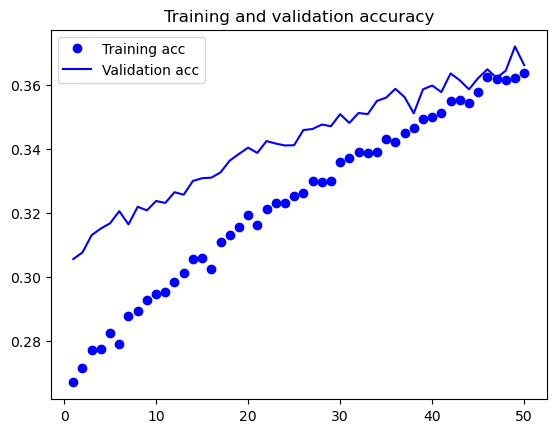

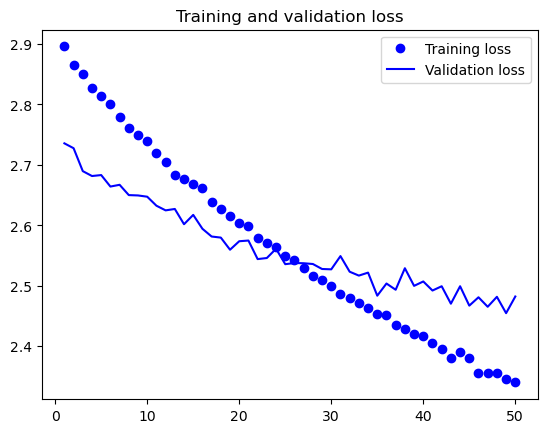

In [34]:
acc = history_model6FT.history['accuracy']
val_acc = history_model6FT.history['val_accuracy']
loss = history_model6FT.history['loss']
val_loss = history_model6FT.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [35]:
np.save('history_model6FT.npy', history_model6FT.history)

This model is trained for 50 epochs, and the improvements are evident with respect to the previous methods. We obtain the best performance so far in both monitored metrics, and, in particular, we reach a validation accuracy of 37%. Moreover, the model has not converged yet, thus we could easily get further improvements in performance, which here are not pursued for computational reasons.

## Evaluation

We conclude the project by evaluating and comparing the produced models on the test set, in particular: the best unregularized one, the best regularized one, and the three models based on VGG16. For computational constraints, we do not try to fit again the final configurations using both training and validation data, which would likely improve performance. Thus, the following results are based on 60\% of the available data for the classes, by which it is clear that the same models, if they were deployed in a novel context after training on validation and test data too, could easily perform better. 

In [24]:
model1 = models.load_model('model1_e30_Best.keras')
model3 = models.load_model('model3_2_e50_Best.keras')
model5 = models.load_model('model5_e20_Best.keras')
model6 = models.load_model('model6_2_e50_Best.keras')
model6FT = models.load_model('model6FT_e50_Best.keras')

In [91]:
test_loss1, test_acc1 = model1.evaluate(test_generator)
test_loss3, test_acc3 = model3.evaluate(test_generator)
test_loss5, test_acc5 = model5.evaluate(test_features, test_labels)
test_loss6, test_acc6 = model6.evaluate(test_generator_2)
test_loss6FT, test_acc6FT = model6FT.evaluate(test_generator_2)

In [31]:
models_names = ['Unreg.', 'Reg.', 'F-EX w/o DA', 'F-EX with DA', 'Fine-tuning']

In [92]:
models_accs = [test_acc1, test_acc3, test_acc5, test_acc6, test_acc6FT]
models_losses = [test_loss1, test_loss3, test_loss5, test_loss6, test_loss6FT]

Below, each model is mapped to its accuracy-loss pair.

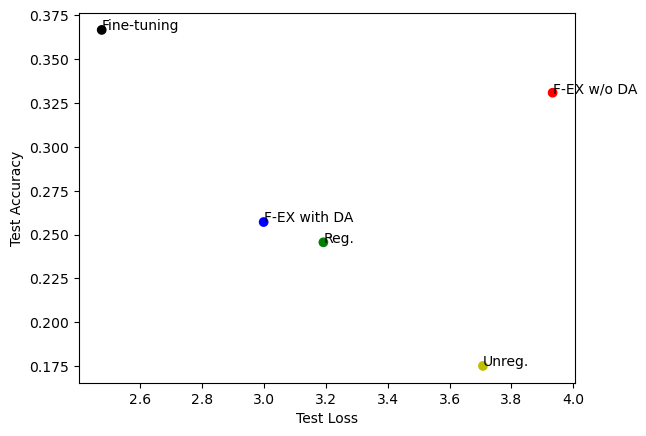

In [93]:
plt.scatter([test_loss1, test_loss3, test_loss5, test_loss6, test_loss6FT],
           [test_acc1, test_acc3, test_acc5, test_acc6, test_acc6FT], c = ['y', 'g', 'r', 'b', 'k'])

for i, model_name in enumerate(models_names):
    plt.annotate(model_name, (models_losses[i], models_accs[i]))
    
plt.xlabel('Test Loss')
plt.ylabel('Test Accuracy')
plt.show()

We observe that the fine-tuned model has the best performance both in terms of accuracy, which only considers matches of the predictions with the true labels, and loss, which is more general, and it is also influenced by the noise in the model's prediction. For 4 of the models, the two plotted metrics exhibit a tight relationship. Instead, the model of feature extraction without data augmentation is an outlier, as it couples second-best accuracy with worst loss. As for the configurations trained from scratch, they are the most underperforming ones in terms of top-1 accuracy, but regularization clearly improves on the first model.

In [27]:
models_accs = np.load('models_accs.npy', allow_pickle='TRUE')
models_losses = np.load('models_losses.npy', allow_pickle='TRUE')

Below, other metrics are computed on the test data set for each model: precision curve, recall curve, and the AUC of the ROC curve, all averaged across classes, and top-5 accuracy.

In [97]:
thresh = np.linspace(0, 1, 200).tolist()
metrics = [keras.metrics.TopKCategoricalAccuracy(k=5), keras.metrics.AUC(num_thresholds = 200),
           keras.metrics.Recall(thresholds = thresh), keras.metrics.Precision(thresholds = thresh)]

In [116]:
model1.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy',
               metrics= metrics)
model1_metrics = model1.evaluate(test_generator)
np.save('model1_metrics.npy', model1_metrics)

92/92 [==============================] - 277s 3s/step - loss: 3.7080 - top_k_categorical_accuracy: 0.4765 - auc_1: 0.8345 - recall_3: 0.1883 - precision_1: 0.5609


In [117]:
model3.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy',
               metrics= metrics)
model3_metrics = model3.evaluate(test_generator)
np.save('model3_metrics.npy', model3_metrics)

92/92 [==============================] - 291s 3s/step - loss: 3.1919 - top_k_categorical_accuracy: 0.4929 - auc_1: 0.8501 - recall_3: 0.1711 - precision_1: 0.5630


In [113]:
test_labels_ohe = keras.utils.to_categorical(test_labels)
model5.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy',
               metrics= metrics)
model5_metrics = model5.evaluate(test_features, test_labels_ohe)
np.save('model5_metrics.npy', model5_metrics)

366/366 [==============================] - 30s 80ms/step - loss: 3.9334 - top_k_categorical_accuracy: 0.5431 - auc_1: 0.8540 - recall_3: 0.2714 - precision_1: 0.6066


In [118]:
model6.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy',
               metrics= metrics)
model6_metrics = model6.evaluate(test_generator_2)
np.save('model6_metrics.npy', model6_metrics)

46/46 [==============================] - 397s 9s/step - loss: 2.9986 - top_k_categorical_accuracy: 0.5083 - auc_1: 0.8619 - recall_3: 0.1656 - precision_1: 0.5693


In [119]:
model6FT.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy',
               metrics= metrics)
model6FT_metrics = model6FT.evaluate(test_generator_2)
np.save('model6FT_metrics.npy', model6FT_metrics)

46/46 [==============================] - 390s 8s/step - loss: 2.4747 - top_k_categorical_accuracy: 0.5450 - auc_1: 0.8760 - recall_3: 0.1855 - precision_1: 0.5813


In [121]:
top5accs = []
AUCs = []
recalls = []
precisions = []
for m in model1_metrics, model3_metrics, model5_metrics, model6_metrics, model6FT_metrics:
    top5accs.append(m[1])
    AUCs.append(m[2])
    precisions.append(m[3])
    recalls.append(m[4])

Below, each model is mapped to its top5_accuracy-AUC pair.

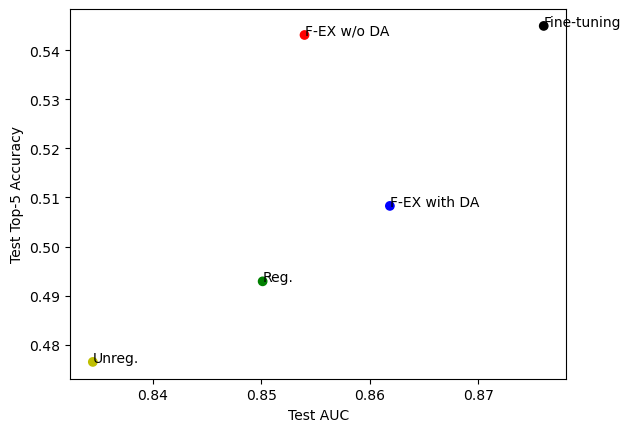

In [122]:
plt.scatter(AUCs, top5accs, c = ['y', 'g', 'r', 'b', 'k'])

for i, model_name in enumerate(models_names):
    plt.annotate(model_name, (AUCs[i], top5accs[i]))
    
plt.xlabel('Test AUC')
plt.ylabel('Test Top-5 Accuracy')
plt.show()

Again, there is a tight relationship between the more general metric, the AUC score, and the most task-specific one, top-5 accuracy. Also in this case, the fine-tuned model strictly dominates all other configurations. The fact that, similarly to what we have seen before, 'unregularized' feature extraction exhibits a good accuracy performance, together with an AUC score which does not fit into the general relationship we observe, makes this model somewhat less reliable than its data-augmented counterpart, which indeed exhibits higher AUC. This coexistence of relatively high accuracy with underperforming general metrics is likely due to overfitting: less regularization  made the model more receptive to generalizable patterns, but also introduced considerable noise in the class predictions.

Below, the average Precision-Recall curves are plotted.

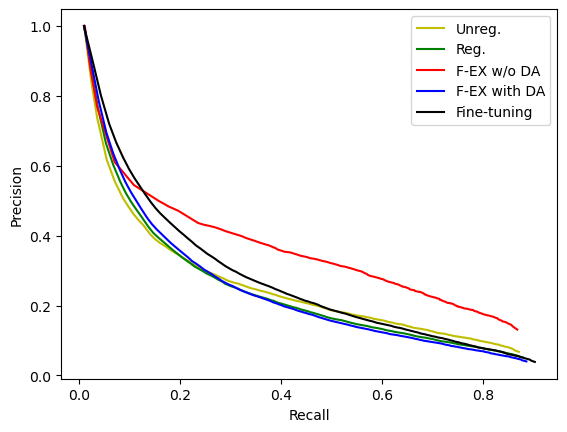

In [148]:
cols =  ['y', 'g', 'r', 'b', 'k']
for i, (model_r, model_p) in enumerate(zip(recalls, precisions)):
    plt.plot(model_r[:-1], model_p[:-1], label = models_names[i], c = cols[i])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

Again we observe the difference in behaviour of the unregularized F-EX model, whose P-R curve exhibits a somewhat different shape from the other networks. The plot shows that, considering the model performance on binary classification for each of its classes, if we want a very precise model, fine-tuned VGG16 can offer greater recall, and is therefore superior, whereas, if we are more interested in recall, F-EX without DA can offer greater precision, hence it is preferable. All others are dominated by the fine-tuned VGG16.

Finally, the following code takes a sample of 10 classes, and plots precision-recall curves for each of them.

In [176]:
sample_classes = np.random.randint(0, max(test_labels)+1, 10)
sample_classes

array([56,  4, 72, 29, 48, 67, 42, 36, 31, 81])

In [177]:
bin_PR = []
for c in sample_classes:
    bin_PR.append(keras.metrics.Recall(thresholds = thresh, class_id = c))
    bin_PR.append(keras.metrics.Precision(thresholds = thresh, class_id = c))

In [188]:
model1.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy',
               metrics= bin_PR)
model1_binRP = model1.evaluate(test_generator)
np.save('model1_binRP.npy', model1_binRP)

92/92 [==============================] - 298s 3s/step - loss: 3.7080 - recall_4: 0.0351 - precision_2: 0.1739 - recall_5: 0.1708 - precision_3: 0.6781 - recall_6: 0.0351 - precision_4: 0.0372 - recall_7: 0.0717 - precision_5: 0.4669 - recall_8: 0.3180 - precision_6: 0.6705 - recall_9: 0.2273 - precision_7: 0.5509 - recall_10: 0.1378 - precision_8: 0.7157 - recall_11: 0.1825 - precision_9: 0.5221 - recall_12: 0.0255 - precision_10: 0.0277 - recall_13: 0.0623 - precision_11: 0.4068


In [189]:
model3.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy',
               metrics= bin_PR)
model3_binRP = model3.evaluate(test_generator)
np.save('model3_binRP.npy', model3_binRP)

92/92 [==============================] - 295s 3s/step - loss: 3.1919 - recall_4: 0.0313 - precision_2: 0.1665 - recall_5: 0.1492 - precision_3: 0.6595 - recall_6: 0.0397 - precision_4: 0.0435 - recall_7: 0.0744 - precision_5: 0.4768 - recall_8: 0.3295 - precision_6: 0.6545 - recall_9: 0.1786 - precision_7: 0.5470 - recall_10: 0.1100 - precision_8: 0.6843 - recall_11: 0.1495 - precision_9: 0.5188 - recall_12: 0.0255 - precision_10: 0.0292 - recall_13: 0.0573 - precision_11: 0.4254


In [179]:
test_labels_ohe = keras.utils.to_categorical(test_labels)
model5.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics =  bin_PR)
model5_binRP = model5.evaluate(test_features, test_labels_ohe)
np.save('model5_binRP.npy', model5_binRP)

366/366 [==============================] - 30s 76ms/step - loss: 3.9334 - recall_4: 0.0497 - precision_2: 0.2329 - recall_5: 0.2877 - precision_3: 0.7505 - recall_6: 0.0397 - precision_4: 0.0384 - recall_7: 0.1029 - precision_5: 0.4796 - recall_8: 0.5112 - precision_6: 0.7570 - recall_9: 0.3279 - precision_7: 0.6192 - recall_10: 0.2002 - precision_8: 0.7754 - recall_11: 0.2886 - precision_9: 0.5761 - recall_12: 0.0118 - precision_10: 0.0046 - recall_13: 0.0750 - precision_11: 0.4990


In [190]:
model6.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy',
               metrics= bin_PR)
model6_binRP = model6.evaluate(test_generator_2)
np.save('model6_binRP.npy', model6_binRP)

46/46 [==============================] - 404s 9s/step - loss: 2.9986 - recall_4: 0.0302 - precision_2: 0.1673 - recall_5: 0.1308 - precision_3: 0.6546 - recall_6: 0.0389 - precision_4: 0.0465 - recall_7: 0.0702 - precision_5: 0.4865 - recall_8: 0.2844 - precision_6: 0.6442 - recall_9: 0.1606 - precision_7: 0.5413 - recall_10: 0.0918 - precision_8: 0.6841 - recall_11: 0.1462 - precision_9: 0.5237 - recall_12: 0.0289 - precision_10: 0.0490 - recall_13: 0.0665 - precision_11: 0.5016


In [191]:
model6FT.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy',
               metrics= bin_PR)
model6FT_binRP = model6FT.evaluate(test_generator_2)
np.save('model6FT_binRP.npy', model6FT_binRP)

46/46 [==============================] - 386s 8s/step - loss: 2.4747 - recall_4: 0.0375 - precision_2: 0.1680 - recall_5: 0.1310 - precision_3: 0.6729 - recall_6: 0.0477 - precision_4: 0.3753 - recall_7: 0.0870 - precision_5: 0.5528 - recall_8: 0.3010 - precision_6: 0.6623 - recall_9: 0.1811 - precision_7: 0.5591 - recall_10: 0.0854 - precision_8: 0.6849 - recall_11: 0.1735 - precision_9: 0.5261 - recall_12: 0.0521 - precision_10: 0.5250 - recall_13: 0.1123 - precision_11: 0.6914


In [192]:
models_binRP = [model1_binRP, model3_binRP, model5_binRP, model6_binRP, model6FT_binRP]

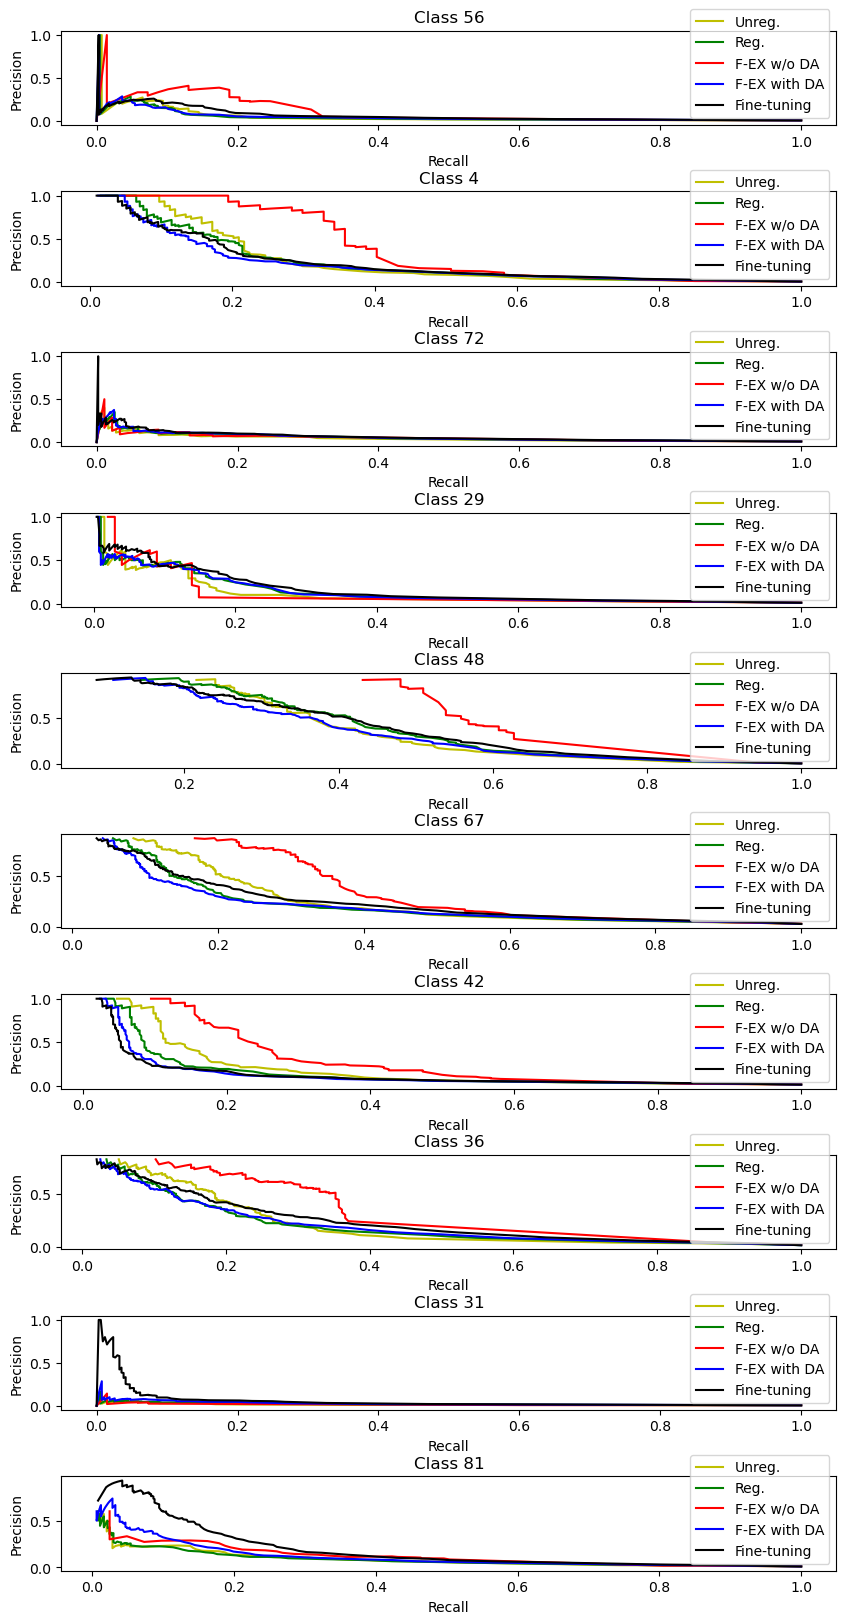

In [207]:
fig, axes = plt.subplots(len(sample_classes))
fig.set_figheight(20)
fig.set_figwidth(10)
plt.subplots_adjust(hspace = 0.7)
s = 0
for c in range(1, len(model1_binRP), 2):
    sample = sample_classes[s]
    for m, metrics in enumerate(models_binRP):
        model_r = metrics[c]
        model_p = metrics[c+1]
        axes[s].set_title('Class '+str(sample))
        axes[s].plot(model_r[:-1], model_p[:-1], label = models_names[m], c = cols[m])
        axes[s].set_xlabel('Recall')
        axes[s].set_ylabel('Precision')
        axes[s].legend(loc = 'best')
    s += 1
plt.show()

Similarly to previous results, by inspecting the Precision-Recall curves for this sample, we observe that the best model, on this metric, is in some cases the fine-tuned pretrained model, and, in other cases, feature extraction without data augmentation. 

**End of Notebook.**